In [15]:
import numpy as np
import pickle
import cv2
from os import listdir
from tensorflow import keras
from keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
K.set_image_data_format('channels_last')
from keras.models import model_from_json
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


In [16]:
EPOCHS = 150
INIT_LR = 1e-4
BS = 32
default_image_size = tuple((227, 227))
image_size = 0
directory_root = 'bgr_rmv_erosion/train'
width=227
height=227
depth=3

In [17]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [18]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for disease_folder in root_dir :
        plant_disease_image_list = listdir(f"{directory_root}/{disease_folder}")
        
        for image in plant_disease_image_list:
            image_directory = f"{directory_root}/{disease_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Image loading completed


In [19]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [20]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0


In [21]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.1, random_state = 42) 

[INFO] Spliting data to train, test


In [22]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30, 
    width_shift_range=0.15,
    height_shift_range=0.15, 
    shear_range=0.15, 
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=(0.2, 1.0), 
    fill_mode="nearest"
)
train = train_datagen.flow(x_train, y_train, batch_size=6)

In [23]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('alexnet_v2.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto') 

In [24]:
def AlexNet(input_shape):   
    X_input = Input(input_shape)
    
    X = Conv2D(96,(11,11),strides = (4,4), name="conv1")(X_input)
    X = Activation('relu')(X)   
    X = BatchNormalization()(X)
    X = MaxPooling2D((3,3),strides = (2,2), padding='same', name = 'pool1')(X)
        
    X = Conv2D(256,(5,5), strides=1, padding = 'same' , name = 'conv2')(X)
    X = Activation('relu')(X)
    X = BatchNormalization()(X)
    X = MaxPooling2D((3,3),strides = (2,2),name = 'pool2')(X)
        
    X = Conv2D(384, (3,3), strides=(1,1), padding = 'same' , name='conv3')(X)
    X = Activation('relu')(X)
        
    X = Conv2D(384, (3,3), strides=(1,1), padding = 'same' , name='conv4')(X)
    X = Activation('relu')(X)
        
    X = Conv2D(384, (3,3), strides=(1,1), padding = 'same' , name='conv5')(X)
    X = Activation('relu')(X)
        
    X = Conv2D(256, (3,3), strides=(1,1), padding = 'same' , name='conv6')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3),strides = (2,2),name = 'pool7')(X)

    X = Flatten()(X)
        
    X = Dense(4096, activation = 'relu', name = "fc8")(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)

    X = Dense(4096, activation = 'relu', name = 'fc9')(X) 
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)

    X = Dense(1000, activation = 'relu', name = 'fc10')(X) 

    X = Dense(3,activation='softmax',name = 'output')(X)
        
    model = Model(inputs = X_input, outputs = X, name='AlexNet')
    return model

In [25]:
alex = AlexNet(train[0][0].shape[1:])


In [26]:
print(train[0][0].shape[1:])

(227, 227, 3)


In [27]:
opt = keras.optimizers.Adam(INIT_LR)
alex.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [28]:
history = alex.fit_generator(
    train, 
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    verbose=1,
    callbacks=[checkpoint]
)

/tmp/ipykernel_9574/2250819448.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = alex.fit_generator(


Epoch 1/150
18/18 [==============================] - ETA: 0s - loss: 1.6398 - accuracy: 0.3148
Epoch 1: val_accuracy improved from -inf to 0.58333, saving model to alexnet_v2.h5
18/18 [==============================] - 25s 1s/step - loss: 1.6398 - accuracy: 0.3148 - val_loss: 1.0960 - val_accuracy: 0.5833
Epoch 2/150
18/18 [==============================] - ETA: 0s - loss: 1.1151 - accuracy: 0.3889
Epoch 2: val_accuracy did not improve from 0.58333
18/18 [==============================] - 22s 1s/step - loss: 1.1151 - accuracy: 0.3889 - val_loss: 1.1116 - val_accuracy: 0.0833
Epoch 3/150
18/18 [==============================] - ETA: 0s - loss: 1.1303 - accuracy: 0.3981
Epoch 3: val_accuracy did not improve from 0.58333
18/18 [==============================] - 21s 1s/step - loss: 1.1303 - accuracy: 0.3981 - val_loss: 1.0912 - val_accuracy: 0.3333
Epoch 4/150
18/18 [==============================] - ETA: 0s - loss: 1.1773 - accuracy: 0.3611
Epoch 4: val_accuracy did not improve from 0.583

In [29]:
model_json = alex.to_json()
with open("alexnet_v2.json", "w") as json_file:
    json_file.write(model_json)

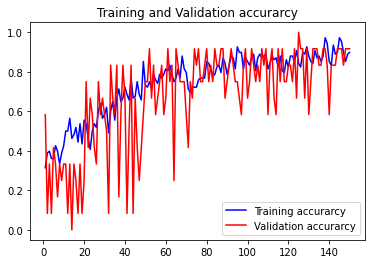

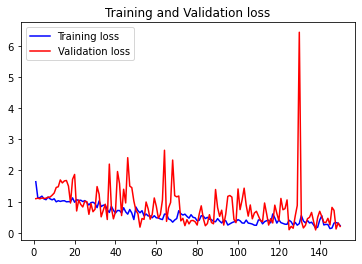

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [31]:
from keras.models import load_model, model_from_json


json_file = open('alexnet_v2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# load weights into new model
loaded_model.load_weights("alexnet_v2.h5")

In [32]:
print("[INFO] Calculating model accuracy")
scores = loaded_model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
1/1 [==============================] - 1s 802ms/step - loss: 0.1001 - accuracy: 1.0000
Test Accuracy: 100.0


In [33]:
scores_bacterialleafblight = loaded_model.evaluate(x_test[y_test[:,0]==1], y_test[y_test[:,0]==1])
print(f"Test Accuracy: {scores_bacterialleafblight[1]*100}")

1/1 [==============================] - 0s 247ms/step - loss: 0.1130 - accuracy: 1.0000
Test Accuracy: 100.0


In [34]:
scores_brownspot = loaded_model.evaluate(x_test[y_test[:,1]==1], y_test[y_test[:,1]==1])
print(f"Test Accuracy: {scores_brownspot[1]*100}")

1/1 [==============================] - 0s 170ms/step - loss: 0.0373 - accuracy: 1.0000
Test Accuracy: 100.0


In [35]:
scores_leafsmut = loaded_model.evaluate(x_test[y_test[:,2]==1], y_test[y_test[:,2]==1])
print(f"Test Accuracy: {scores_leafsmut[1]*100}")

1/1 [==============================] - 0s 100ms/step - loss: 0.2618 - accuracy: 1.0000
Test Accuracy: 100.0
